In [14]:
using POMDPs
using POMDPModelTools 
using POMDPPolicies 
using QuickPOMDPs
using Parameters, Random 

In [15]:
using Plots; default(fontfamily="Computer Modern", framestyle=:box) # LaTex-style

In [16]:
struct State
	x::Int
	y::Int
end

In [17]:
𝒮 = [[State(x,y) for x=1:params.size[1], y=1:params.size[2]]..., params.null_state]

101-element Vector{State}:
 State(1, 1)
 State(2, 1)
 State(3, 1)
 State(4, 1)
 State(5, 1)
 State(6, 1)
 State(7, 1)
 State(8, 1)
 State(9, 1)
 State(10, 1)
 State(1, 2)
 State(2, 2)
 State(3, 2)
 ⋮
 State(10, 9)
 State(1, 10)
 State(2, 10)
 State(3, 10)
 State(4, 10)
 State(5, 10)
 State(6, 10)
 State(7, 10)
 State(8, 10)
 State(9, 10)
 State(10, 10)
 State(-1, -1)

In [18]:
@with_kw struct GridWorldParameters
	size::Tuple{Int,Int} = (10, 10)   # size of the grid
	null_state::State = State(-1, -1) # terminal state outside of the grid
	p_transition::Real = 0.7 # probability of transitioning to the correct next state
end	

GridWorldParameters

In [22]:
params = GridWorldParameters();

In [39]:
begin
	function one_based_policy!(policy)
		# change the default action in the policy (all zeros) to all ones (if needed)
		if all(iszero, policy.policy)
			policy.policy[:] = ones(eltype(policy.policy), length(policy.policy))
		end
	end
    function get_rewards(mdp::QuickMDP{GridWorld}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->reward(mdp, s), valid_states)
    end
    function values(mdp::QuickMDP{GridWorld}, policy::Policy)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = map(s->value(policy, s), valid_states)
    end
    function values(mdp::QuickMDP{GridWorld}, planner::MCTSPlanner)
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        U = []
        for s in valid_states
            u = 0
            try
                u = value(planner, s)
            catch
                # state not in tree
            end
            push!(U, u)
        end
        return U
    end
    function values(mdp::QuickMDP{GridWorld}, policy::ValuePolicy)
        maxU = mapslices(maximum, policy.value_table, dims=2)
        return maxU[1:end-1] # remove null_state
    end
    struct NothingPolicy <: Policy end
    
    # Use this to get a stationary grid of rewards
    function values(mdp::QuickMDP{GridWorld}, policy::Union{NothingPolicy, FunctionPolicy})
        null_state = params.null_state
        valid_states = setdiff(states(mdp), [null_state])
        rewards = map(s->reward(mdp, s), valid_states)
    end
end

LoadError: error in method definition: function Base.values must be explicitly imported to be extended

In [40]:
struct NothingPolicy <: Policy end

In [54]:
function plot_grid_world(mdp::MDP,
        policy::Policy=NothingPolicy(), # our policy will have states State(c, t, f, v) with actions (reject/accept)
        iter=0,
        discount=NaN; 
        outline=true,
        show_policy=true,
        extra_title=isnan(discount) ? "" : " (iter=$iter, γ=$discount)",
        show_rewards=false,
        outline_state::Union{State, Nothing}=nothing)
    
    gr()
	
    if policy isa NothingPolicy # if there is no policy 
        # override when the policy is empty
        show_policy = false
    end
    
    if iter == 0
        # solver has not been run yet, so we just plot the raw rewards
        # overwrite policy at time=0 to be emp
        U = get_rewards(mdp, policy)
    else
        # otherwise, use the Value Function to get the values (i.e., utility)
        U = values(mdp, policy)
    end
    # reshape to grid
    (xmax, ymax) = params.size
    Uxy = reshape(U, xmax, ymax)
    # plot values (i.e the U matrix)
    fig = heatmap(Uxy',
                  legend=:none,
                  aspect_ratio=:equal,
                  framestyle=:box,
                  tickdirection=:out,
                  #color=cmap.colors)
        )
    xlims!(0.5, xmax+0.5)
    ylims!(0.5, ymax+0.5)
    xticks!(1:xmax)
    yticks!(1:ymax)
    rectangle(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    
    if show_rewards
        for s in filter(s->reward(mdp, s) != 0, states(mdp))
            r = reward(mdp, s)
            annotate!([(s.x, s.y, (r, :white, :center, 12, "Computer Modern"))])
        end
    end
    
    for x in 1:xmax, y in 1:ymax
        # display policy on the plot as arrows
        if show_policy
            grid = policy_grid(policy, xmax, ymax)
            annotate!([(x, y, (grid[x,y], :center, 12, "Computer Modern"))])
        end
        if outline
            rect = rectangle(1, 1, x - 0.5, y - 0.5)
            plot!(rect, fillalpha=0, linecolor=:gray)
        end
    end
    if !isnothing(outline_state)
        terminal_states = filter(s->reward(mdp, s) != 0, states(mdp))
        color = (outline_state in terminal_states) ? "yellow" : "blue"
        rect = rectangle(1, 1, outline_state.x - 0.5, outline_state.y - 0.5)
        plot!(rect, fillalpha=0, linecolor=color)
    end
    title!("Grid World Policy Plot$extra_title")
    return fig
end


plot_grid_world (generic function with 4 methods)

In [42]:
render = plot_grid_world

plot_grid_world (generic function with 4 methods)

In [43]:
Base.:(==)(s1::State, s2::State) = (s1.x == s2.x) && (s1.y == s2.y)

In [44]:
@enum Action UP DOWN LEFT RIGHT

In [45]:
𝒜 = [UP, DOWN, LEFT, RIGHT]

4-element Vector{Action}:
 UP::Action = 0
 DOWN::Action = 1
 LEFT::Action = 2
 RIGHT::Action = 3

In [46]:
begin
	const MOVEMENTS = Dict(UP    => State(0,1),
						   DOWN  => State(0,-1),
						   LEFT  => State(-1,0),
						   RIGHT => State(1,0));

	Base.:+(s1::State, s2::State) = State(s1.x + s2.x, s1.y + s2.y)
end

In [47]:
function T(s::State, a::Action)
	if R(s) != 0
		return Deterministic(params.null_state)
	end

	Nₐ = length(𝒜)
	next_states = Vector{State}(undef, Nₐ + 1)
	probabilities = zeros(Nₐ + 1)
	p_transition = params.p_transition

	for (i, a′) in enumerate(𝒜)
		prob = (a′ == a) ? p_transition : (1 - p_transition) / (Nₐ - 1)
		destination = s + MOVEMENTS[a′]
		next_states[i+1] = destination

		if inbounds(destination)
			probabilities[i+1] += prob
		end
	end
	
	# handle out-of-bounds transitions
	next_states[1] = s
	probabilities[1] = 1 - sum(probabilities)

	return SparseCat(next_states, probabilities)
end

T (generic function with 1 method)

In [48]:
inbounds(s::State) = 1 ≤ s.x ≤ params.size[1] && 1 ≤ s.y ≤ params.size[2]

inbounds (generic function with 1 method)

In [49]:
function R(s, a=missing)
	if s == State(4,3)
		return -10
	elseif s == State(4,6)
		return -5
	elseif s == State(9,3)
		return 10
	elseif s == State(8,8)
		return 3
	else
		return 0
	end
end

R (generic function with 2 methods)

In [22]:
#@bind γ Slider(0:0.05:1, default=0.95, show_value=true)

LoadError: LoadError: UndefVarError: @bind not defined
in expression starting at In[22]:1

In [50]:
termination(s::State) = s == params.null_state

termination (generic function with 1 method)

In [51]:
abstract type GridWorld <: MDP{State, Action} end

In [52]:
mdp = QuickMDP(GridWorld,
    states       = 𝒮,
    actions      = 𝒜,
    transition   = T,
    reward       = R,
    #discount     = γ,
    initialstate = 𝒮,
    isterminal   = termination,
	render       = render);

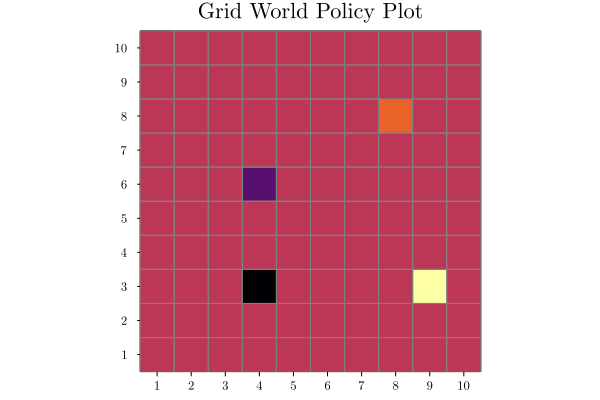

In [55]:
render(mdp)

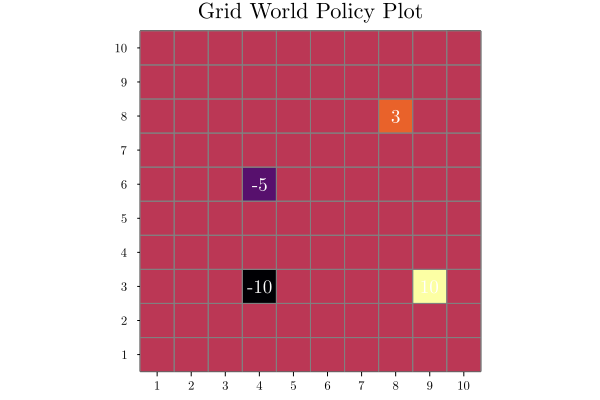

In [56]:
render(mdp; show_rewards=true)